Выполнено по [статье](https://martian1231-py.medium.com/region-proposal-network-rpn-in-faster-rcnn-from-scratch-in-keras-1311c67c13cf)

In [2]:
import cv2
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

from io import BytesIO
from PIL import Image
from typing import List, Literal, Tuple, Union

%matplotlib inline

Загрузим изображение и определим положение объектов на нем с помощью bounding boxes.

Размер избражения: 624 х 416
Соотношение сторон: 1.5


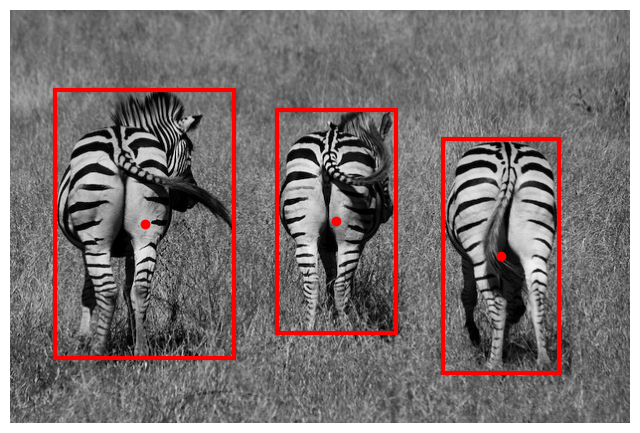

In [172]:
def plot_img(img: Image, bboxes: np.ndarray = None, figsize=(8, 8), plot_centers: bool = True, color: str = "r") -> None:
    print("Размер избражения: %s х %s" % img.size)
    print("Соотношение сторон: %s" % (img.width / img.height))

    _, ax = plt.subplots(figsize=figsize)
    if bboxes is not None:
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            w = x2 - x1
            h = y2 - y1
            xc, yc = x1 + w / 2, y1 + h / 2
            rect = Rectangle(xy=(x1, y1), width=w, height=h, facecolor="none", edgecolor=color, linewidth=3)
            ax.add_patch(rect)

            if plot_centers:
                ax.scatter(x=xc, y=yc, c="r")
    ax.set_axis_off()
    ax.imshow(img)
    return ax


img_url = "http://farm4.staticflickr.com/3020/2631046560_d08a45b9dd_z.jpg"
responce = requests.get(img_url)
img = Image.open(BytesIO(responce.content))

# обрезаем изображение для удобства, чтобы делилось на 16-ть целочисленно
# при использовании faster RCNN это делать не нужно
left, top, right, bottom = 0, 0, img.width - img.width % 16, img.height - img.height % 16
img = img.crop((left, top, right, bottom))

# в формате xyxy
ground_truth = np.array([
    [45, 80, 225, 350],
    [268, 100, 388, 325],
    [435, 130, 552, 365],
])

plot_img(img=img, bboxes=ground_truth, figsize=(8, 8));

Сеть VGG16 переводит изображение $c \times H \times W$ в feature map размера $c \times \frac{H}{16} \times \frac{W}{16}$. Каждый суперпиксель feature map имеет $k = 9$ anchor boxes. Отметим их центры на изображении.

In [173]:
vgg_scale = 16

w_feature_map = img.width / vgg_scale
h_feature_map = img.height / vgg_scale

w_stride = img.width / w_feature_map
h_stride = img.height / h_feature_map

x_points = np.arange(start=vgg_scale / 2, step=w_stride, stop=img.width, dtype="int32")
y_points = np.arange(start=vgg_scale / 2, step=h_stride, stop=img.height, dtype="int32")

points = np.array(np.meshgrid(x_points, y_points, sparse=False, indexing="xy")).T.reshape(-1, 2)

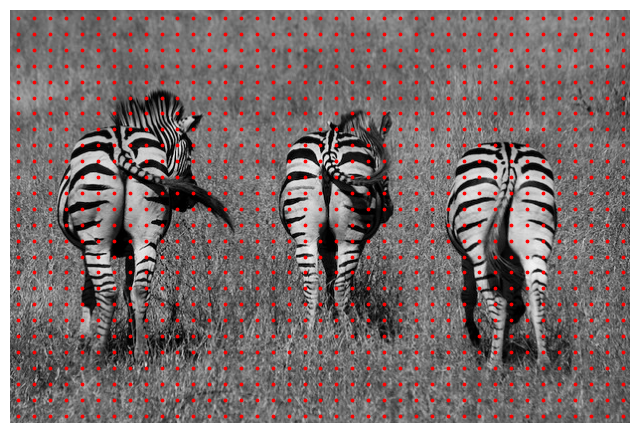

In [174]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x=points[:, 0], y=points[:, 1], c="r", s=3)
ax.set_axis_off()
ax.imshow(img);

На примере одного из суперпикселей отобразим все anchor boxes для этого суперпикселя. В оригинальной статье используются anchor boxes
- с размерами
    - $128^{2}$
    - $256^{2}$
    - $512^{2}$
- с соотношениями сторон:
    - 1:1
    - 2:1
    - 1:2

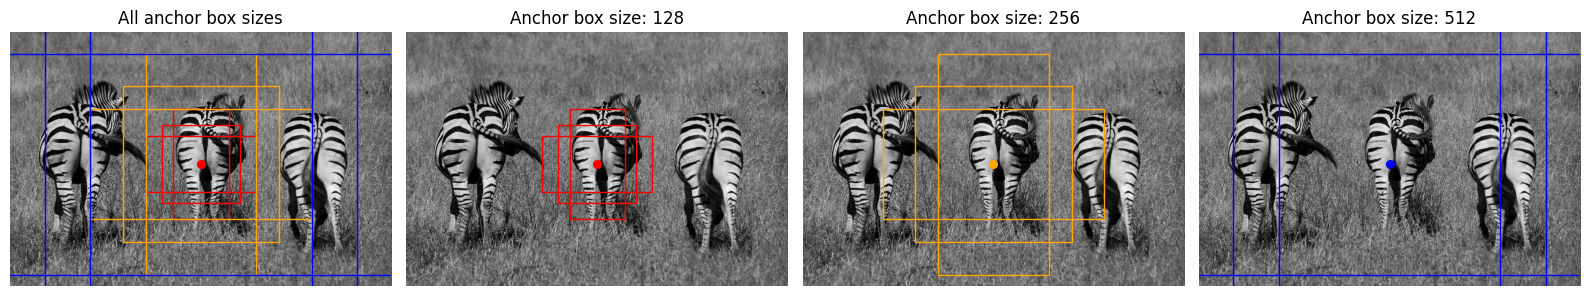

In [175]:
def ab_generator(sizes: Union[int, List[int]], scales: Union[float, List[float]],
                 return_size_and_scale: bool = False) -> Tuple[float]:
    if not isinstance(sizes, list):
        sizes = [sizes]
    if not isinstance(scales, list):
        scales = [scales]
        
    for size in sizes:
        for scale in scales:
            x = size / np.sqrt(scale)

            if return_size_and_scale:
                yield x, x*scale, size, scale
            else:
                yield x, x*scale


ab_sizes = [128, 256, 512]
ab_scales = [0.5, 1.0, 2.0]
color = ["red", "orange", "blue"]

idx_p = len(points) // 2
xc, yc = points[idx_p, 0], points[idx_p, 1]
fig, ax = plt.subplots(ncols=4, figsize=(4*4, 4))

for idx, size in enumerate(ab_sizes):
    ax[idx + 1].scatter(x=xc, y=yc, c=color[idx], s=30)
    for w, h in ab_generator(sizes=size, scales=ab_scales):
        x = xc - w / 2
        y = yc - h / 2
        ax[0].add_patch(Rectangle(xy=(x, y), width=w, height=h, facecolor="none", edgecolor=color[idx], linewidth=1))
        ax[idx + 1].add_patch(Rectangle(xy=(x, y), width=w, height=h, facecolor="none", edgecolor=color[idx], linewidth=1))
    ax[idx + 1].set_title(label="Anchor box size: %s" % size)
    ax[idx + 1].imshow(img)
    ax[idx + 1].set_axis_off()

ax[0].set_title(label="All anchor box sizes")
ax[0].scatter(x=xc, y=yc, c="r", s=30)
ax[0].imshow(img)
ax[0].set_axis_off()
fig.tight_layout();

Сформируем таблицу со всеми anchor boxes для всех суперпикселей изображения

In [365]:
anchor_boxes = []
for anchor_id, (x_center, y_center) in enumerate(points):
    for w, h, size, ratio in ab_generator(sizes=ab_sizes, scales=ab_scales, return_size_and_scale=True):
        anchor_boxes.append((anchor_id, size, ratio, x_center, y_center, w, h))

df = pd.DataFrame(anchor_boxes, columns=["anchor_id", "anchor_box_size", "anchor_box_ratio", "x_c", "y_c", "w", "h"])
df.insert(loc=0, column="anchor_box_id", value=range(0, len(df)))

# рассчитаем координаты верхнего левого угла (x1, y1) и правого нижнего (x2, y2)
df["x_1"] = df["x_c"] - df["w"]/2
df["y_1"] = df["y_c"] - df["h"]/2
df["x_2"] = df["x_c"] + df["w"]/2
df["y_2"] = df["y_c"] + df["h"]/2

# отметим те anchor boxes, которые находятся за пределами изображения
# создадим бинарный признак: 
# True - не выходит за пределы изображения, 
# False - выходит за пределы изображения
df["anchor_box_inside"] = (
    df["x_1"].between(left=0, right=img.width, inclusive="both") &
    df["y_1"].between(left=0, right=img.height, inclusive="both") &
    df["x_2"].between(left=0, right=img.width, inclusive="both") &
    df["y_2"].between(left=0, right=img.height, inclusive="both")
)

print(df.shape)
display(df.head(5))

(9126, 13)


,anchor_box_id,anchor_id,anchor_box_size,anchor_box_ratio,x_c,y_c,w,h,x_1,y_1,x_2,y_2,anchor_box_inside
0,0,0,128,0.5,8,8,181.019336,90.509668,-82.509668,-37.254834,98.509668,53.254834,False
1,1,0,128,1.0,8,8,128.000000,128.000000,-56.000000,-56.000000,72.000000,72.000000,False
2,2,0,128,2.0,8,8,90.509668,181.019336,-37.254834,-82.509668,53.254834,98.509668,False
3,3,0,256,0.5,8,8,362.038672,181.019336,-173.019336,-82.509668,189.019336,98.509668,False
4,4,0,256,1.0,8,8,256.000000,256.000000,-120.000000,-120.000000,136.000000,136.000000,False


Посчитаем $IoU$ между всеми anchor boxes и ground truth boxes

In [366]:
def intersection_over_union(bbox_a: np.ndarray, bbox_b: np.ndarray, 
                            epsilon: float = 1e-6) -> np.ndarray:
    """
    Функция рассчета IoU. На вход принимает два bounding box и рассчитывает IoU между ними.
    :param bbox_a: first bounding box parameters [x1, y1, x2, y2]
                   где x1 и y1 - координаты левого нижнего угла bounding box
                   x2 и y2 - координаты правого верхнего угла bounding box
    :param bbox_b: second bounding box parameters [x1, y1, x2, y2]
                   где x1 и y1 - координаты левого нижнего угла bounding box
                   x2 и y2 - координаты правого верхнего угла bounding box
    :param epsilon: в случае, когда Union между двумя bounding boxes равен 0, в формуле рассчета 
                    IoU мы получаем деление на 0 (т.к. Union стоит в знаменателе). Чтобы избежать 
                    деление на 0 к Union добавляется константа epsilon, default to 1e-6
    """    
    # intersection of with and height as overlap x and y axises
    w_intersection = np.clip(
        np.minimum(bbox_a[:, 2, np.newaxis], bbox_b[np.newaxis, :, 2]) - \
        np.maximum(bbox_a[:, 0, np.newaxis], bbox_b[np.newaxis, :, 0]), 0, np.inf)
    h_intersection = np.clip(
        np.minimum(bbox_a[:, 3, np.newaxis], bbox_b[np.newaxis, :, 3]) - \
        np.maximum(bbox_a[:, 1, np.newaxis], bbox_b[np.newaxis, :, 1]), 0, np.inf)
    
    # intersection area
    intersection = w_intersection * h_intersection
    
    # union area, area_a is area of the rectangle bbox_a, area_b is area of the rectangle bbox_b
    area_a = (bbox_a[:, 2] - bbox_a[:, 0])*\
            (bbox_a[:, 3] - bbox_a[:, 1])
    area_b = (bbox_b[:, 2] - bbox_b[:, 0])*\
            (bbox_b[:, 3] - bbox_b[:, 1])
    union = np.abs(area_a[:, np.newaxis] + area_b[np.newaxis, :]) - intersection

    # calculating IoU for two rectangles bbox_a and bbox_b
    return intersection / (union + epsilon)


# рассчитаем значения IoU между anchor boxes и ground truth boxes
iou = intersection_over_union(bbox_a=df[["x_1", "y_1", "x_2", "y_2"]].values, bbox_b=ground_truth)
iou_cols = ["IoU_object_%s" % i for i in range(0, iou.shape[1])]
df.loc[:, iou_cols] = iou

# выберем максимальное значение IoU для каждого из anchor boxes и соотнесем с соответствующим ground truth box
df["max_iou"] = df[iou_cols].max(axis=1)
df["best_gt"] = np.argmax(df[iou_cols], axis=1)

# классифицирем результаты по IoU на три категории:
# - object:     1 - для anchor boxes с max IoU >= 0.7 и anchor boxes, имеющим максимальный IoU для данного ground truth box
# - background: 0 - для anchor boxes с max IoU < 0.3
# - ignore:    -1 - для остальных anchor boxes
label_col = np.full(shape=(len(df)), fill_value=-1)
label_col[((df["max_iou"] < 0.3)  & (df["anchor_box_inside"] == True)).values] = 0
label_col[((df["max_iou"] >= 0.7) & (df["anchor_box_inside"] == True)).values] = 1
label_col[df.loc[df["anchor_box_inside"] == True, iou_cols].idxmax(axis=0).values] = 1
df["label"] = label_col

print(df.shape)
display(df.head(5))

(9126, 19)


,anchor_box_id,anchor_id,anchor_box_size,anchor_box_ratio,x_c,y_c,w,h,x_1,y_1,x_2,y_2,anchor_box_inside,IoU_object_0,IoU_object_1,IoU_object_2,max_iou,best_gt,label
0,0,0,128,0.5,8,8,181.019336,90.509668,-82.509668,-37.254834,98.509668,53.254834,False,0.000000,0.0,0.0,0.000000,0,-1
1,1,0,128,1.0,8,8,128.000000,128.000000,-56.000000,-56.000000,72.000000,72.000000,False,0.000000,0.0,0.0,0.000000,0,-1
2,2,0,128,2.0,8,8,90.509668,181.019336,-37.254834,-82.509668,53.254834,98.509668,False,0.002357,0.0,0.0,0.002357,0,-1
3,3,0,256,0.5,8,8,362.038672,181.019336,-173.019336,-82.509668,189.019336,98.509668,False,0.023914,0.0,0.0,0.023914,0,-1
4,4,0,256,1.0,8,8,256.000000,256.000000,-120.000000,-120.000000,136.000000,136.000000,False,0.046735,0.0,0.0,0.046735,0,-1


In [367]:
# проверка функции intersection_over_union для рассчета IoU
bbox_a = np.array([
    [3, 2, 8, 6],
    [-3, 2, 2, 6],
    [1, 4, 6, 9],
])
bbox_b = np.array([
    [1, 4, 6, 9],
    [1, 4, 6, 9]
])
intersection_over_union(bbox_a, bbox_b)

array([[0.15384615, 0.15384615],
       [0.04651163, 0.04651163],
       [0.99999996, 0.99999996]])

Отобразим на картинке anchor boxes c label == 1

Размер избражения: 624 х 416
Соотношение сторон: 1.5


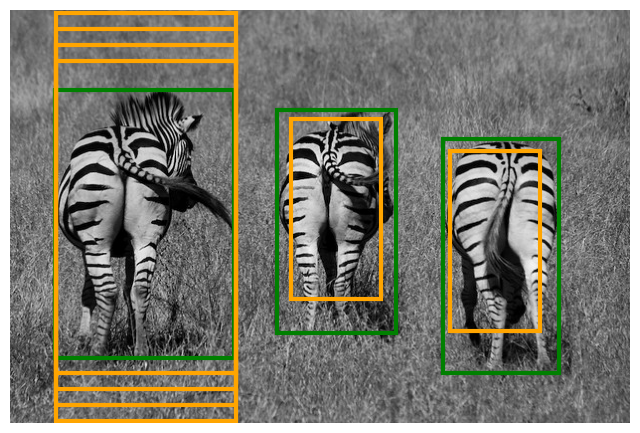

In [368]:
ax = plot_img(img=img, bboxes=ground_truth, figsize=(8, 8), plot_centers=False, color="green")
for _, row in df[df["label"] == 1].iterrows():
    rect = Rectangle(xy=(row["x_1"], row["y_1"]), width=row["w"], height=row["h"], facecolor="none", edgecolor="orange", linewidth=3)
    ax.add_patch(rect)

Описание полученной таблицы:
- `anchor_box_id` - ID anchor box (для каждого из анкоров у нас их 9)
- `anchor_id` - ID анкора (суперпикселя). Их на нашем изображении 1014
- `anchor_box_size` - размер anchor box (в оригинальной статье на Faster RCNN было 3 размера - {$128^{2}$, $256^{2}$, $512^{2}$})
- `anchor_box_ratio` - соотношение сторон anchor box (в оригинальной статье на Faster RCNN было 3 соотношения сторон - {1:2, 1:1, 2:1})
- `x_c` - $X$ координата центра anchor box
- `y_c` - $Y$ координата центра anchor box
- `w` - ширина anchor box
- `h` - высота anchor box
- `x_1` - $X$ координата левого нижнего угла anchor box
- `y_1` - $Y$ координата левого нижнего угла anchor box
- `x_2` - $X$ координата правого верхнего угла anchor box
- `y_2` - $Y$ координата правого верхнего угла anchor box
- `anchor_box_inside` - True, если anchor box не выходит за пределы изображения
- `IoU_object_0` - значение IoU c ground truth с индексом 0
- `IoU_object_1` - значение IoU c ground truth с индексом 1
- `IoU_object_2` - значение IoU c ground truth с индексом 2
- `max_iou` - максимальное значение IoU из рассчитанных для данного anchor box со всеми ground truth boxes
- `best_gt` - индекс ground truth box, который имеет максимальное значение с текущим anchor box
- `label` - классифицирем результаты по IoU на три категории:  
    - object:     1 - для anchor boxes с max IoU >= 0.7 и anchor boxes, имеющим максимальный IoU для данного ground truth box  
    - background: 0 - для anchor boxes с max IoU < 0.3  
    - ignore:    -1 - для остальных anchor boxes

Баланс классов (колонка `labels`)

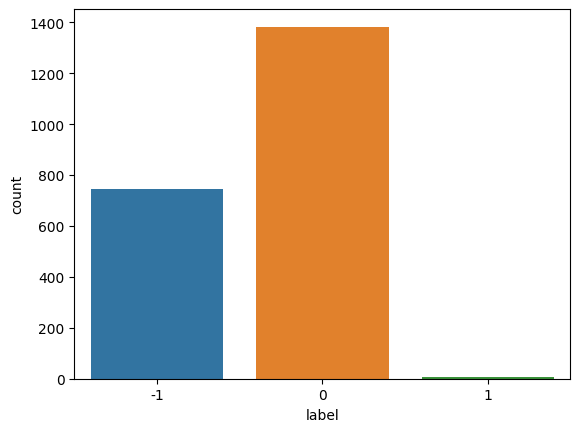

In [369]:
sns.countplot(x=df[df["anchor_box_inside"] == True]["label"]);

In [370]:
df[df["anchor_box_inside"] == True]["label"].value_counts()

label
 0    1383
-1     747
 1       6
Name: count, dtype: int64

#### Balancing Anchor Labels And Creating Mini Batch Of 256 Anchors

Как видим, по классам выборка не сбалансированная. Большинство anchor boxes принадлежат классу 0 - т.е. backgroud. Сбалансируем и создадим mini-batch из 256 anchor boxes.

In [371]:
minibatch = df.copy()

n_samples = 256  # размер mini-batch, который необходимо сгенерить
neg_ratio = 0.5  # процент anchor boxes, который принадлежит классу 0 (backgroud)
n_foreground = int(n_samples*(1 - neg_ratio))  # количество anchor boxes класса 1, которое должно быть в идеале в minibatch
n_background = n_samples - n_foreground  # количество anchor boxes класса 0, которое должно быть в идеале в minibatch
print("Идеальное количество anchor boxes для minibatch размера %s:" % n_samples)
print("\tКласса 0 (background): %s" % n_background)
print("\tКласса 1 (foreground): %s\n" % n_foreground)

n_foreground_real = np.sum(minibatch["label"] == 1)
n_background_real = np.sum(minibatch["label"] == 0)
print("Количество anchor boxes класса 1 в исходной выборке: %s" % n_foreground_real)
print("Количество anchor boxes класса 0 в исходной выборке: %s\n" % n_background_real)

# смотрим, есть ли превышение по "оптимальному" количеству anchor boxes класса 1
# если есть, то корректируем
if n_foreground_real > n_foreground:
    n_ignore = n_foreground_real - n_foreground
    ignore_idx = minibatch[minibatch["label"] == 1].sample(n_ignore).index
    minibatch.loc[ignore_idx, "label"] = -1

# далее смотрим, если у нас нет достаточного количества anchor boxes с клаасом 1, до дополняем minibatch anchor boxes класса 0
# (увеличиваем их количество)
if n_foreground_real < n_foreground:
    diff = n_foreground - n_foreground_real
    n_background += diff

# смотрим, есть ли превышение n_background по количеству anchor boxes класса 0
# если есть, то корректируем
if n_background_real > n_foreground:
    n_ignore = n_background_real - n_background
    ignore_idx = minibatch[minibatch["label"] == 0].sample(n_ignore).index
    minibatch.loc[ignore_idx, "label"] = -1

print("Итоговое количество anchor boxes для minibatc размера %s:" % n_samples)
print("\tКласса 0 (background): %s" % len(minibatch[minibatch["label"] == 0]))
print("\tКласса 1 (foreground): %s\n" % len(minibatch[minibatch["label"] == 1]))


Идеальное количество anchor boxes для minibatch размера 256:
	Класса 0 (background): 128
	Класса 1 (foreground): 128

Количество anchor boxes класса 1 в исходной выборке: 6
Количество anchor boxes класса 0 в исходной выборке: 1383

Итоговое количество anchor boxes для minibatc размера 256:
	Класса 0 (background): 250
	Класса 1 (foreground): 6



#### Computing Anchor Offset For Each Anchor Box To Assigned Ground Truth Box

Для каждого anchor box рассчитаем offsets (формулы на примере координаты $X$ и величины $W$):

$$ \Delta x = (x - x_{a}) / w_{a} $$
$$ \Delta w = \log{(w / w_{a})} $$

Наша модель должна научиться предсказывать эти величины. Т.е. это таргеты для соответствующих объектов.

In [380]:
gt_xywh = np.array([
    (ground_truth[:, 0] + ground_truth[:, 2]) / 2,
    (ground_truth[:, 1] + ground_truth[:, 3]) / 2,
     ground_truth[:, 2] - ground_truth[:, 0], 
     ground_truth[:, 3] - ground_truth[:, 1],
])
gt_xywh = pd.DataFrame(data=gt_xywh.T, columns=["gt_x", "gt_y", "gt_w", "gt_h"])
minibatch = minibatch.merge(gt_xywh, how="left", left_on="best_gt", right_index=True)

minibatch["delta_x"] = (minibatch["gt_x"] - minibatch["x_c"])/minibatch["w"]
minibatch["delta_y"] = (minibatch["gt_y"] - minibatch["y_c"])/minibatch["h"]
minibatch["delta_w"] = np.log(minibatch["gt_w"]/minibatch["w"])
minibatch["delta_h"] = np.log(minibatch["gt_h"]/minibatch["h"])

display(gt_xywh)
display(minibatch.head())

,gt_x,gt_y,gt_w,gt_h
0,135.0,215.0,180.0,270.0
1,328.0,212.5,120.0,225.0
2,493.5,247.5,117.0,235.0


,anchor_box_id,anchor_id,anchor_box_size,anchor_box_ratio,x_c,y_c,w,h,x_1,y_1,...,best_gt,label,gt_x,gt_y,gt_w,gt_h,delta_x,delta_y,delta_w,delta_h
0,0,0,128,0.5,8,8,181.019336,90.509668,-82.509668,-37.254834,...,0,-1,135.0,215.0,180.0,270.0,0.701583,2.287048,-0.005647,1.092965
1,1,0,128,1.0,8,8,128.000000,128.000000,-56.000000,-56.000000,...,0,-1,135.0,215.0,180.0,270.0,0.992188,1.617188,0.340927,0.746392
2,2,0,128,2.0,8,8,90.509668,181.019336,-37.254834,-82.509668,...,0,-1,135.0,215.0,180.0,270.0,1.403165,1.143524,0.687500,0.399818
3,3,0,256,0.5,8,8,362.038672,181.019336,-173.019336,-82.509668,...,0,-1,135.0,215.0,180.0,270.0,0.350791,1.143524,-0.698794,0.399818
4,4,0,256,1.0,8,8,256.000000,256.000000,-120.000000,-120.000000,...,0,-1,135.0,215.0,180.0,270.0,0.496094,0.808594,-0.352221,0.053245


#### Loss calculation

При расчете loss задачи классификации (есть объект / нет объекта) не берутся во внимание $labels == -1$. А в задаче регрессии для координат bboxes берутся во внимание только $labels == 1$.